## 卷积运算的基础
### 简单2维卷积的互相关运算
### 卷积涉及的参数, kernel, stride, padding, 计算的公式
### 多维度输入的卷积计算, 多维度输出的卷积计算
### 卷积池化的计算, max, average



In [66]:
import torch    

In [67]:
x = torch.arange(9).reshape(3, 3)

In [68]:
k = torch.arange(4).reshape(2, 2)

### 简单2维卷积的互相关运算

In [69]:
def my_conv2d(X, K):
    (x_h, x_w) = X.shape
    (k_h, k_w) = K.shape
    res = torch.zeros((k_h, k_w))
    for i in range (x_w - k_w + 1):
        for j in range (x_h - k_h + 1): 
            res[i, j] = (X[i:i+k_h,j:j+k_w] * K).sum()
    return res 

In [70]:
my_conv2d(x, k)

tensor([[19., 25.],
        [37., 43.]])

### 填充和步符(padding, stride), p 泛指两侧
#### 1.不参与stride的卷积输出 (n - k + p + 1) X (n - k + p + 1)
#### 2.参与strdie的卷积输出 (n - k + p + 1 + s) / s  X  (n - k + p + 1 + s) / s

### 多输入通道和多输出通道的卷积核

#### 当输入数据含多个通道时，我们需要构造一个输入通道数与输入数据的通道数相同的卷积核，从而能够与含多通道的输入数据做互相关运算

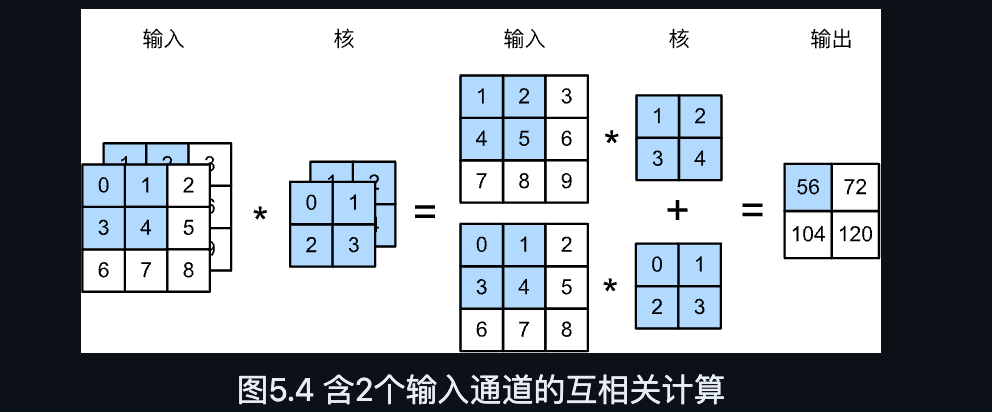

In [96]:
## 实现简单的多输入通道的互相关运算
def my_multi_in_conv2d(X, K):
    res = my_conv2d(X[0, :, :], K[0, :, :])
    for i in range (1, X.shape[0]):
        res += my_conv2d(X[i, :, :], K[i, :, :])
    return res


In [97]:
X1 = torch.arange(0, 9).reshape(-1, 3, 3)

In [98]:
X2 = torch.arange(1, 10).reshape(-1, 3, 3)

In [99]:
X3 = torch.cat((X1, X2), dim=0)

In [100]:
K1 = torch.arange(0, 4).reshape(-1, 2, 2)

In [101]:
K2 = torch.arange(1, 5).reshape(-1, 2, 2)

In [102]:
K3 = torch.cat((K1, K2), dim=0)

In [103]:
my_multi_in_conv2d(X3, K3)

tensor([[ 56.,  72.],
        [104., 120.]])

### 多输出通道
当输入通道有多个时，因为我们对各个通道的结果做了累加，所以不论输入通道数是多少，输出通道数总是为1。设卷积核输入通道数和输出通道数分别为$c_i$和$c_o$，高和宽分别为$k_h$和$k_w$。如果希望得到含多个通道的输出，我们可以为每个输出通道分别创建形状为$c_i\times k_h\times k_w$的核数组。将它们在输出通道维上连结，卷积核的形状即$c_o\times c_i\times k_h\times k_w$。在做互相关运算时，每个输出通道上的结果由卷积核在该输出通道上的核数组与整个输入数组计算而来。

In [104]:
def my_multi_in_out(X, K):
    return torch.stack([my_multi_in_conv2d(X, k) for k in K]) 

In [105]:
K4 = torch.stack([K3, K3 + 1, K3 + 2])

In [116]:
my_multi_in_out(X3, K4)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 池化层

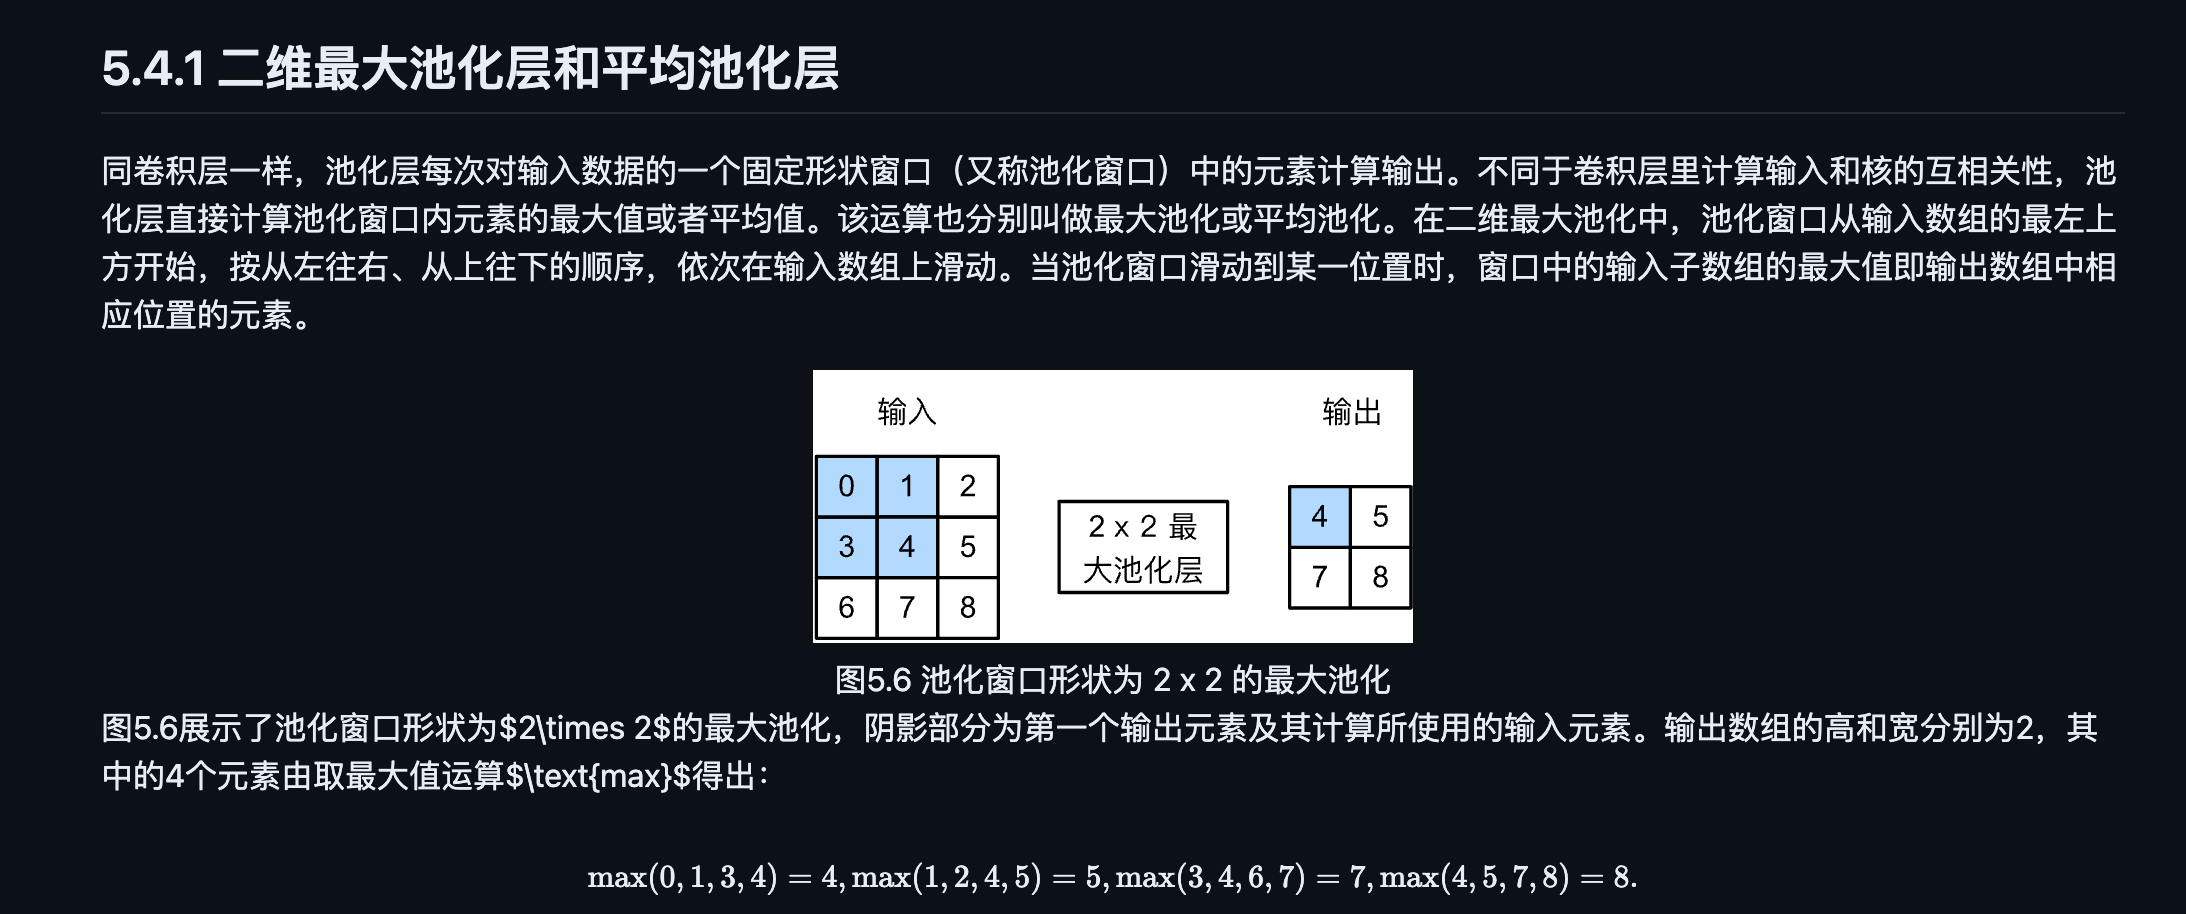

In [125]:
## 简单池化层的实现
def pool2d(X, pool_size, mode='max'):
    (pk_h, pk_w) = pool_size
    (n_h, n_w) = X.shape
    y = torch.zeros(n_h - pk_h + 1, n_w - pk_w + 1)
    for i in range (y.shape[0]):
        for j in range (y.shape[1]):
            if mode == 'max':
                y[i,j] = X[i:i+pk_h, j:j+pk_w].max()
            else:
                y[i,j] = X[i:i+pk_h, j:j+pk_w].mean()
    return y

In [126]:
pool2d(torch.arange(0, 9).reshape(3, 3), (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [128]:
pool2d(torch.arange(0, 9, dtype=torch.float).reshape(3, 3), (2, 2), mode='avg')

tensor([[2., 3.],
        [5., 6.]])

### 填充和步幅

同卷积层一样，池化层也可以在输入的高和宽两侧的填充并调整窗口的移动步幅来改变输出形状。池化层填充和步幅与卷积层填充和步幅的工作机制一样。我们将通过nn模块里的二维最大池化层MaxPool2d来演示池化层填充和步幅的工作机制。我们先构造一个形状为(1, 1, 4, 4)的输入数据，前两个维度分别是批量和通道。

In [129]:
X = torch.arange(16, dtype=torch.float).view((1, 1, 4, 4))

In [134]:
pool2d = nn.MaxPool2d(3, stride=2, padding=1)

In [135]:
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### 多通道

在处理多通道输入数据时，池化层对每个输入通道分别池化，而不是像卷积层那样将各通道的输入按通道相加。这意味着池化层的输出通道数与输入通道数相等。下面将数组X和X+1在通道维上连结来构造通道数为2的输入。



In [138]:
X = torch.cat((X, X + 1), dim=1)
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]],

         [[ 6.,  8.],
          [14., 16.]],

         [[ 7.,  9.],
          [15., 17.]]]])